In [62]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.preprocessing import normalize
import numpy as np
import itertools
from collections import defaultdict

%load_ext autoreload
%autoreload 2
from tools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Partie 1 : SIFT

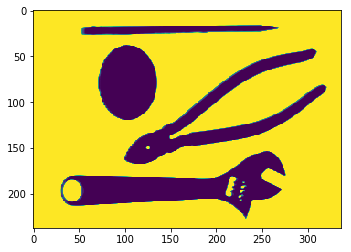

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

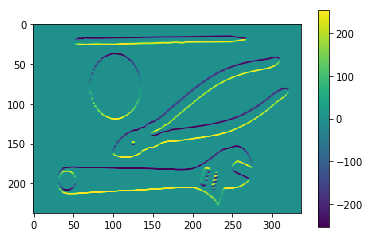

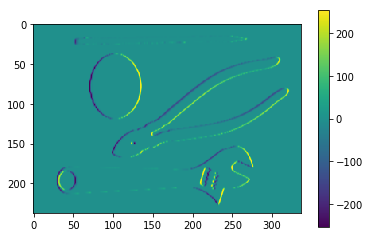

In [3]:
def compute_grad(I):
    hb = 0.5*np.array([-1,0,1])
    ha = 0.5*np.array([1,2,1])
    Ix = conv_separable(I, ha, hb)
    Iy = conv_separable(I, hb, ha)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)

#Ix : matrice des dérivées en x
#Iy : matrice des dérivées en y
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [4]:
def get_norme(Ix, Iy):
    return np.sqrt(Ix * Ix + Iy * Iy)

def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = get_norme(Ix, Iy)
    Go = compute_grad_ori(Ix, Iy, Gm)
    #compute_grad_ori(g_xn g_y, g_m, b)
    # g_x: image gradient x-axis (w,h)
    # g_y: image gradient y-axis (w,h)
    # g_m: image gradient module (w,h)
    # b: orientation bins
    # g_o: image gradient orientation (w,h)
    
    return Gm, Go

In [5]:
Gm, Go = compute_grad_mod_ori(I)

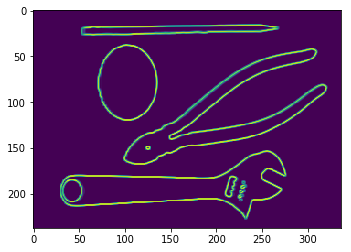

In [6]:
plt.imshow(Gm)

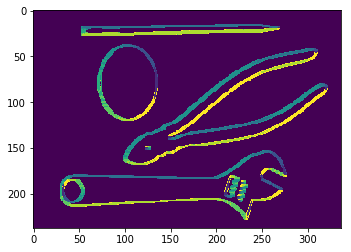

In [7]:
plt.imshow(Go)

In [7]:
def compute_sift_region(Gm, Go, mask=None):
    # TODO
    #Gm et Go sont de dimensions 16 x 16, on considère que les patchs sont déja formé !
    # Note: to apply the mask only when given, do:
    if mask is not None:
        #le masque est de taille 16 * 16. On l'applique à un patch en multipliant
        #terme à terme les 2 matrices
        Gm = Gm * mask
        
    a, b = Gm.shape
    it = itertools.product(range(0,a,4), range(0,b,4))
    d = defaultdict(lambda : np.zeros(8))
    for i, j in itertools.product(range(a), range(b)):
        key = (i // 4, j // 4)
        d[key][Go[i, j]] += Gm[i, j]
    
    res = np.array(list(d.values()))
    res = res.reshape(-1)
                   
    #post-processing
    norme = np.linalg.norm(res, ord=2)
    if norme < 0.5:
        return np.zeros(128)
    #normalisation
    res = res / norme
    sift = np.minimum(res, 0.2)
    sift = sift / np.linalg.norm(sift, ord=2)
    return sift

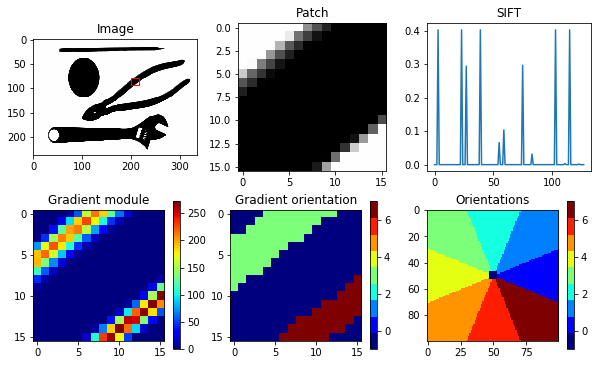

array([0.        , 0.        , 0.        , 0.4024072 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.4024072 , 0.        ,
       0.        , 0.        , 0.29382397, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.4024072 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06597825, 0.        , 0.        , 0.        , 0.10378698,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [8]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [9]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    # TODO calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            Gm, Go = compute_grad_mod_ori(I[xi:xi+16, yj:yj+16])
            sifts[i, j, :] = compute_sift_region(Gm, Go)
    return sifts

In [10]:
sifts = compute_sift_image(I)

In [11]:
import scipy
scipy.stats.describe(sifts.reshape(-1))

DescribeResult(nobs=165120, minmax=(0.0, 0.8563542516980144), mean=0.008929003490934067, variance=0.00326331591577175, skewness=7.116574797876851, kurtosis=52.859527298148656)

# Partie 2 : Dictionnaire visuel

In [13]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
# from path import Path
from tools import *
from sift import *
from scipy.stats import describe
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
DATA = Path("/Vrac/giveMeQuota/rdfia/data")

In [14]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [15]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [30]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=0):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    m = KMeans(n_clusters=n_clusters, n_init=n_init, verbose=verbose)
    m.fit(sift)
    centers = m.cluster_centers_
    v = np.zeros((1, 128))
    res = np.concatenate((centers, v), axis=0)
    return res
    

In [17]:
compute_visual_dict(sifts_list_by_image, n_clusters=10, verbose=0)

array([[ 47.68220312,  38.50021956,  45.24967066, ...,  73.31095916,
         50.31641679,  43.64901825],
       [ 83.91273727,  84.77849352,  91.4719574 , ...,  11.45581036,
          7.71089925,  12.41990896],
       [ 41.25532643,  47.13245486, 115.71190211, ...,  47.71712159,
        113.25113374,  45.67579362],
       ...,
       [ 31.8890406 ,  19.07837247,  13.07200073, ...,  78.77753504,
         86.50136537,  83.66329874],
       [ 61.23322636,  75.46496702, 115.48962976, ...,  93.94814881,
        113.07826707,  73.98674749],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [32]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)
#pour remettre les données en format 255
vdict = vdict / 255

Computing or loading visual dict
Computing or loading SIFTs


In [33]:
vdict

array([[0.        , 0.        , 0.03137255, ..., 0.        , 0.94117647,
        0.        ],
       [0.25920881, 0.22340557, 0.20694874, ..., 0.31514276, 0.37772274,
        0.2278913 ],
       [0.29482908, 0.29279889, 0.42608017, ..., 0.40294985, 0.21027243,
        0.12453583],
       ...,
       [0.12084523, 0.10567295, 0.17738435, ..., 0.12322482, 0.07310109,
        0.13181039],
       [0.46965088, 0.40275466, 0.19602104, ..., 0.43060736, 0.31355332,
        0.16912482],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(264, 264)
(232, 344)
(232, 352)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(232, 304)
(232, 344)
(264, 264)
(232, 344)
(264, 264)
(232, 304)
(232, 304)
(264, 264)
(232, 304)
(232, 304)
(304, 232)
(264, 264)
(232, 344)
(208, 280)
(232, 336)
(232, 240)
(208, 272)
(232, 392)
(264, 264)
(264, 264)
(264, 264)
(232, 352)
(264, 264)
(264, 264)
(264, 264)
(232, 304)
(264, 264)
(232, 304)
(264, 264)
(232, 344)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(232, 304)
(264, 264)
(264, 264)
(232, 304)
(232, 328)
(232, 336)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(232, 344)
(264, 264)
(232, 328)
(232, 304)
(344, 232)
(264, 264)
(232, 288)
(232, 344)
(264, 264)
(264, 264)
(232, 296)
(232, 296)
(264, 264)
(232, 352)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(232, 336)
(304, 232)
(264, 264)
(232, 304)
(264, 264)
(264, 264)
(232, 304)
(232, 352)
(264, 264)
(232, 344)
(232, 344)
(232, 304)
(232, 304)
(232, 328)

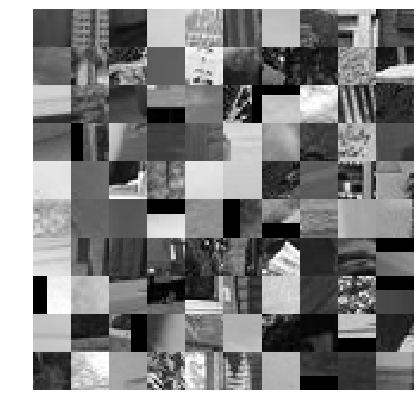

In [47]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 100, replace=False)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

In [48]:
sifts.shape

(105303, 128)

In [49]:
sifts = sifts/255

In [50]:
vdict.shape

(1001, 128)

In [51]:
similarity = vdict @ sifts.T
vdict_norm = np.sum(vdict * vdict, axis=1).reshape(-1, 1)
x_norm = np.sum(sifts * sifts, axis=1).reshape(1, -1)
dists = x_norm + -2 * similarity + vdict_norm

In [52]:
best_sift_cluster = dists.argmin(axis=1)

In [53]:
vd_regions = np.array([regions[id] for id in best_sift_cluster])

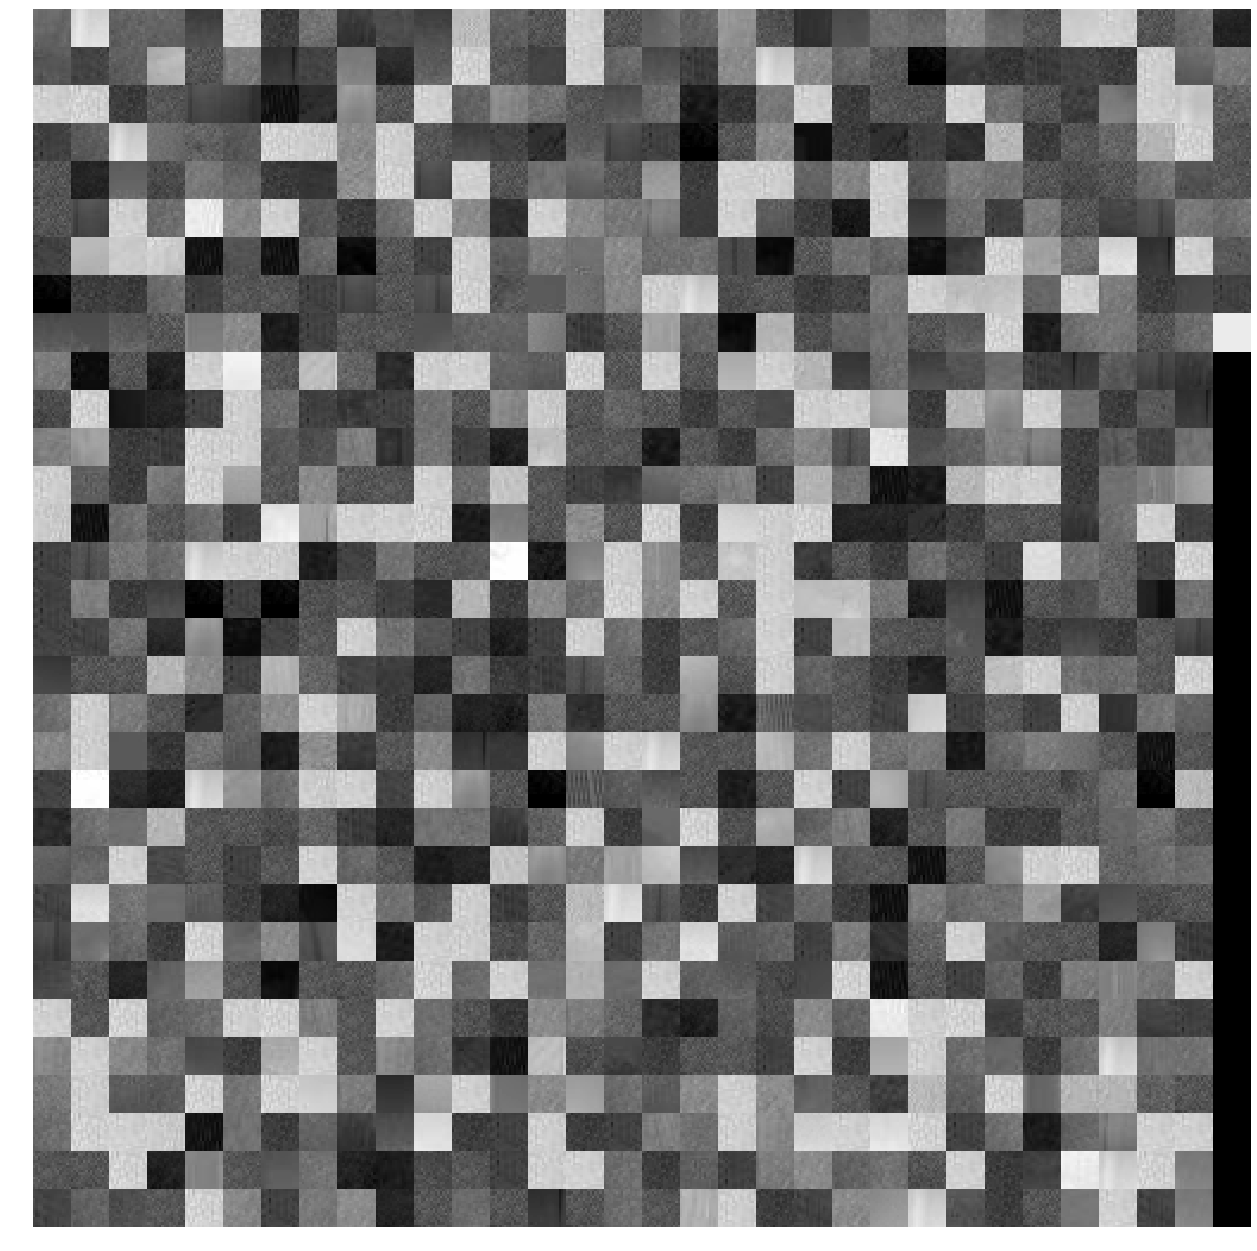

In [54]:
display_images(vd_regions)

# Partie 3 : BoW

In [55]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    images=image_sifts.reshape(-1,image_sifts.shape[2])
    #multiplication matricielle entre vdict et image_sifts
    similarity = vdict @ images.T
    vdict_norm = np.sum(vdict * vdict, axis=1).reshape(-1, 1)
    x_norm = np.sum(images * images, axis=1).reshape(1, -1)
    dists = x_norm + -2 * similarity + vdict_norm
    
    #coding
    min_rows = dists.min(axis=0)
    coding = (dists - min_rows) == 0    
    
    #pooling
    bow = coding.sum(axis=1)
    #normalisation
    return bow / np.linalg.norm(bow, ord=2)
    

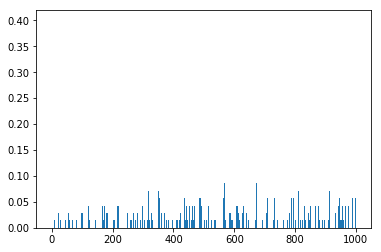

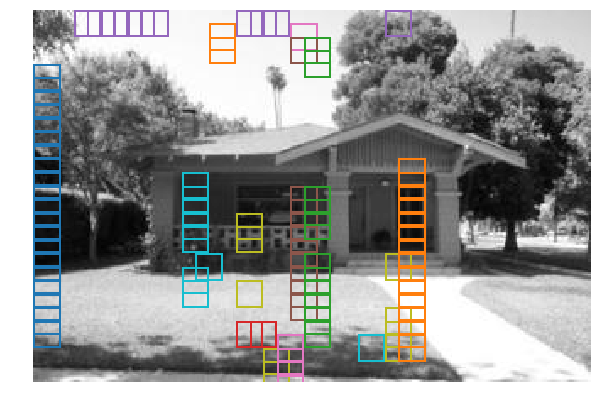

(9, 16, 16)


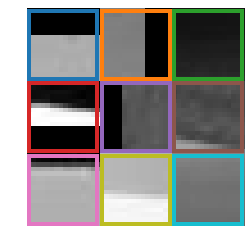

In [18]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=vd_regions) # if you have vdregions, add it as input here

In [57]:
import matplotlib.pyplot as plt

In [64]:
import os
#from tqdm import tqdm
from glob import glob

import matplotlib
import matplotlib.pyplot as mplt
import matplotlib.pyplot as plt
import numpy as np


# Very simplified tqdm
class tqdm:
    def __init__(self, data):
        self.data = data
        self.iter = iter(data)

    def __iter__(self):
        for i, x in enumerate(self.data):
            print("{}/{}\r".format(i + 1, len(self.data)), end="")
            yield x

    def __len__(self):
        return len(self.data)


# size: mask size (will be square)
# sigma: sigma gaussian parameter
def gaussian_mask(size=16, sigma=0.5):
    sigma *= size
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# s: stride


def dense_sampling(im, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    return x, y


def auto_padding(im, k=16, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    # last region could be smaller
    last_r = im[x[-1]:x[-1] + k, y[-1]:y[-1] + k]
    if last_r.shape == (k, k):
        return im
    dif_w = k - last_r.shape[0]
    dif_h = k - last_r.shape[1]
    n_im = np.zeros((w + dif_w, h + dif_h))
    id_w = dif_w // 2
    id_h = dif_h // 2
    n_im[id_w:id_w + w, id_h:id_h + h] = im
    return n_im


def conv_separable(im, h_x, h_y, pad=1):
    h_x = h_x.reshape(1, 3)
    h_y = h_y.reshape(3, 1)

    im_w, im_h = im.shape
    hx_w, hx_h = h_x.shape
    hy_w, hy_h = h_y.shape

    h_x_t = h_x.transpose()
    h_y_t = h_y.transpose()

    if hx_w != 1:
        raise ValueError()
    if hx_h % 2 != 1:
        raise ValueError()
    if hy_h != 1:
        raise ValueError()
    if hy_w % 2 != 1:
        raise ValueError()
    if hx_h != hy_w:
        raise ValueError()

    dim_p = (hx_h - 1) // 2  # dim padding

    # Toeplitz matrices
    t_x = np.zeros((im_h + 2 * dim_p, im_h))
    t_y = np.zeros((im_w, im_w + 2 * dim_p))
    for i in range(im_h):
        t_x[i:i + hx_h, [i]] = h_x_t
    for i in range(im_w):
        t_y[[i], i:i + hy_w] = h_y_t

    # padding on colomn
    im_yp = np.zeros((im_w, im_h + 2 * dim_p))
    im_yp[:, dim_p:im_h + dim_p] = im

    if pad == 1:
        # copy padding
        for i in range(dim_p):
            im_yp[:, i] = im[:, 0]
            im_yp[:, im_h + dim_p + i] = im[:, im_h - 1]

    # conv of filtre h_x
    g = np.dot(im_yp, t_x)

    # padding on line
    g_xp = np.zeros((im_w + 2 * dim_p, im_h))
    g_xp[dim_p:im_w + dim_p, :] = g

    if pad == 1:
        # copy padding
        for i in range(dim_p):
            g_xp[i, :] = g[0, :]
            g_xp[im_w + dim_p + i, :] = g[im_w - 1, :]

    g = np.dot(t_y, g_xp)
    return g

# g_x: image gradient x-axis (w,h)
# g_y: image gradient y-axis (w,h)
# g_m: image gradient module (w,h)
# b: orientation bins
# g_o: image gradient orientation (w,h)


def compute_grad_ori(g_x, g_y, g_m, b=8):
    ori = np.zeros((b, 2))
    for i in range(b):
        ori[i, 0] = np.cos(2 * np.pi * i / b)
        ori[i, 1] = np.sin(2 * np.pi * i / b)
    w, h = g_m.shape
    # TODO: algebraic form
    g_o = np.zeros((w, h))
    for i in range(w):
        for j in range(h):
            if g_m[i, j] > 0:
                v = np.array([g_y[i, j], -g_x[i, j]])
                v = v / np.linalg.norm(v, ord=2)
                prod = np.dot(ori, v)
                g_o[i, j] = np.argmax(prod)
            else:
                g_o[i, j] = -1
    g_o = g_o.astype(int)
    return g_o


def read_grayscale(path):
    img = mplt.imread(path)
    if len(img.shape) > 2:
        if img.shape[2] == 1:
            img = img[:, :, 0]
        else:
            img = 0.2 * img[:, :, 0] + 0.7 * img[:, :, 1] + 0.1 * img[:, :, 2]
    return img


def orientation_colors():
    w = 100
    h = 100
    b = 8
    pix = 3
    ori = np.zeros((b, 2))
    for i in range(b):
        ori[i, 0] = np.cos(2 * np.pi * i / b)
        ori[i, 1] = np.sin(2 * np.pi * i / b)
    g_o = np.zeros((w, h))
    for i in range(w):
        for j in range(h):
            v = np.array([j - h / 2, -i + w / 2])
            #v = np.array([i-w/2, -j+h/2])
            prod = np.dot(ori, v)
            g_o[i, j] = np.argmax(prod)
    g_o[w // 2 - pix:w // 2 + pix, h // 2 - pix:h // 2 + pix] = -1
    return g_o


def display_sift_region(
        im,
        compute_grad_mod_ori,
        compute_sift_region,
        x=200,
        y=78,
        k=16,
        gausm=True):
    g_m, g_o = compute_grad_mod_ori(im)
    if gausm:
        m = gaussian_mask()
    else:
        m = None
    g_m_r = g_m[y:y + k, x:x + k]
    g_o_r = g_o[y:y + k, x:x + k]
    sift = compute_sift_region(g_m_r, g_o_r, m)

    b = 8
    cmap = cmap_discretize('jet', b + 1)

    mplt.figure(figsize=(10, 6))
    ax = mplt.subplot(2, 3, 1)
    mplt.imshow(im, cmap='gray', vmin=0, vmax=255)
    rect = matplotlib.patches.Rectangle(
        (x, y), k, k, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    mplt.title("Image")

    mplt.subplot(2, 3, 2)
    mplt.imshow(im[y:y + k, x:x + k], cmap='gray', vmin=0, vmax=255)
    mplt.title("Patch")

    mplt.subplot(2, 3, 4)
    mplt.imshow(g_m[y:y + k, x:x + k], cmap='jet')
    mplt.colorbar()
    mplt.title("Gradient module")

    mplt.subplot(2, 3, 6)
    ori_map = orientation_colors()
    mplt.imshow(ori_map, cmap=cmap, vmin=-1, vmax=b - 1)
    mplt.colorbar()
    mplt.title("Orientations")

    mplt.subplot(2, 3, 5)
    mplt.imshow(g_o[y:y + k, x:x + k], cmap=cmap, vmin=-1, vmax=b - 1)
    mplt.colorbar()
    mplt.title("Gradient orientation")

    mplt.subplot(2, 3, 3)
    mplt.plot(sift)
    mplt.title("SIFT")

    mplt.show()

    return sift


def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet.
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = matplotlib.cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki],
                       colors_rgba[i, ki]) for i in range(N + 1)]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(
        cmap.name + "_%d" % N, cdict, 1024)


def toy_im():
    im = np.zeros((256, 256))
    im[:100, :100] = 255
    im[:100, 105:] = 255
    im[105:, 105:] = 255
    im[105:, :100] = 255
    return im


def marche_im():
    im = np.zeros((256, 256))
    im[:130, :130] = 255
    return im


def listdir(path):
    return [os.path.basename(p) for p in glob(os.path.join(path, '*'))]


def load_dataset(dir_sc):
    inames = []
    ilabls = []
    cnames = sorted(listdir(dir_sc))
    for ilabl, cl in enumerate(cnames):
        dir_cl = os.path.join(dir_sc, cl)
        for iname in listdir(dir_cl):
            inames.append(os.path.join(cl, iname))
            ilabls.append(ilabl)
    ilabls = np.array(ilabls)
    return inames, ilabls, cnames


def compute_sift(dir_imgs, dir_sift, iname, compute_sift_image):
    ipath = os.path.join(dir_imgs, iname)
    im = read_grayscale(ipath)
    if im is None:
        print('Failed:', ipath)
        return None
    sift = compute_sift_image(im)
    sift = (sift * 255).astype('uint8')
    spath = os.path.join(dir_sift, iname)[:-4]  # remove .jpg
    sdir = os.path.dirname(spath)
    os.makedirs(sdir, exist_ok=True)
    np.save(spath, sift)
    return sift


def compute_load_sift_dataset(dir_imgs, dir_sift, inames, compute_sift_image):
    sift = []
    print("Computing or loading SIFTs")
    for iname in tqdm(inames):
        spath = os.path.join(dir_sift, iname)[:-4] + '.npy'
        if os.path.isfile(spath):
            sift.append(load_sift(dir_sift, iname))
        else:
            sift.append(
                compute_sift(
                    dir_imgs,
                    dir_sift,
                    iname,
                    compute_sift_image))
    return sift


def compute_sift_dataset(dir_imgs, dir_sift, inames, compute_sift_image):
    sift = []
    for iname in tqdm(inames):
        sift.append(
            compute_sift(
                dir_imgs,
                dir_sift,
                iname,
                compute_sift_image))
    return sift


def load_sift(dir_sift, iname):
    spath = os.path.join(dir_sift, iname)[:-4] + '.npy'
    sift = np.load(spath)
    return sift


def load_sift_dataset(dir_sift, inames):
    sift = []
    for iname in tqdm(inames):
        sift.append(load_sift(dir_sift, iname))
    return sift


def compute_split(length, seed=1337, pc=0.80):
    train_ids = np.random.RandomState(seed=seed).choice(
        length,
        size=int(length * pc),
        replace=False)
    test_ids = np.array(list(set(np.arange(length)) - set(train_ids)))
    return train_ids, test_ids


def compute_or_load_vdict(
        dir_sc,
        dir_sift,
        inames,
        compute_sift_image,
        path_vdict,
        compute_vdict):
    print("Computing or loading visual dict")
    if os.path.isfile(path_vdict):
        return np.load(open(path_vdict, "rb"))
    else:
        sifts_list_by_image = compute_load_sift_dataset(
            dir_sc, dir_sift, inames, compute_sift_image)

        vdict = compute_vdict(sifts_list_by_image)
        np.save(open(path_vdict, "wb"), vdict)
        return vdict


def compute_regions(im, k=16, s=8):
    x, y = dense_sampling(im)  # before padding
    im = auto_padding(im)
    images = np.zeros((x.shape[0], y.shape[0], k, k))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            images[i, j] = im[x[i]:x[i] + k, y[j]:y[j] + k]
    return images


def get_regions_and_sifts(dir_sc, inames):
    from sift import compute_sift_image

    vdpaths = [os.path.join(dir_sc, iname) for iname in inames]

    regions = []
    sift = []
    for path in vdpaths:
        im = read_grayscale(path)
        regions.append(compute_regions(im))
        sift.append(compute_sift_image(im))

    k = regions[0].shape[-1]
    n_reg = np.array([r.shape[0] * r.shape[1] for r in regions])
    cs_reg = np.cumsum(n_reg)

    regions = [r.reshape(-1, k, k) for r in regions]
    regions = np.concatenate(regions, axis=0)

    sift = [s.reshape(-1, sift[0].shape[-1]) for s in sift]
    sift = np.concatenate(sift, axis=0)

    return regions, sift


def display_images(images):
    n_images, w, h = images.shape
    n = int(np.ceil(np.sqrt(n_images)))
    im = np.zeros((n * w, n * h))
    for k in range(n_images):
        i = k % n
        j = k // n
        im[i * w:i * w + w, j * h:j * h + h] = images[k]

    mplt.figure(figsize=(0.7 * n, 0.7 * n))
    mplt.gray()
    mplt.imshow(im)
    mplt.axis('off')
    mplt.show()


def display_vdregions(images, colors=None):
    n_images, w, h = images.shape
    n = int(np.ceil(np.sqrt(n_images)))
    im = np.zeros((n * w, n * h))
    for k in range(n_images):
        i = k % n
        j = k // n
        im[i * w:i * w + w, j * h:j * h + h] = images[k]

    fig, ax = plt.subplots(1)
    plt.axis('off')
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

    for k in range(n_images):
        i = k % n * w
        j = k // n * h
        rect = matplotlib.patches.Rectangle(
            (i, j), w - 1, h - 1,
            linewidth=4,
            edgecolor=colors[k],
            facecolor='none')
        ax.add_patch(rect)

    plt.show()


def display_vdregions_image(
        im,
        vdict,
        sift,
        feats,
        colors=None,
        vdregions=None):
    from sklearn.metrics.pairwise import euclidean_distances
    if colors is None:
        colors = ['tab:blue',
                  'tab:orange',
                  'tab:green',
                  'tab:red',
                  'tab:purple',
                  'tab:brown',
                  'tab:pink',
                  'tab:olive',
                  'tab:cyan',
                  'tab:gray']

    plt.figure()
    plt.bar(range(feats.shape[0]), feats)
    plt.show()

    ids = feats.argsort()[-9:][::-1]
    if vdregions is not None:
        vdregions = vdregions[ids]

    fig, ax = plt.subplots(1)
    fig.set_size_inches(10, 10)
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

    if vdregions is None:
        vdregions = [None] * 9
    w = h = 16
    for i in range(sift.shape[0]):
        for j in range(sift.shape[1]):
            dist = euclidean_distances(vdict, sift[i, j].reshape(1, -1))
            word_id = int(dist.argmin(axis=0)[0])

            nonzero = np.nonzero(ids == word_id)[0]
            if nonzero.size == 0:
                continue

            id_ = nonzero[0]
            if vdregions[id_] is None:
                vdregions[id_] = im[i * 8:i * 8 + 16, j * 8:j * 8 + 16]

            rect = matplotlib.patches.Rectangle(
                (i * 8, j * 8), w - 1, h - 1,
                linewidth=2,
                edgecolor=colors[id_],
                facecolor='none')
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()

    for i in range(9):
        if vdregions[i] is None:
            vdregions[i] = np.zeros((16, 16))
    if type(vdregions) == list:
        vdregions = np.stack(vdregions)
    print(vdregions.shape)
    display_vdregions(vdregions, colors=colors)


(232, 344)


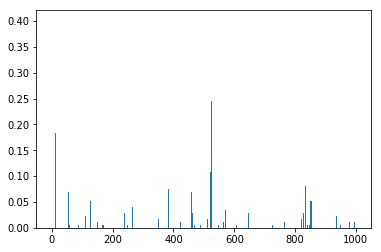

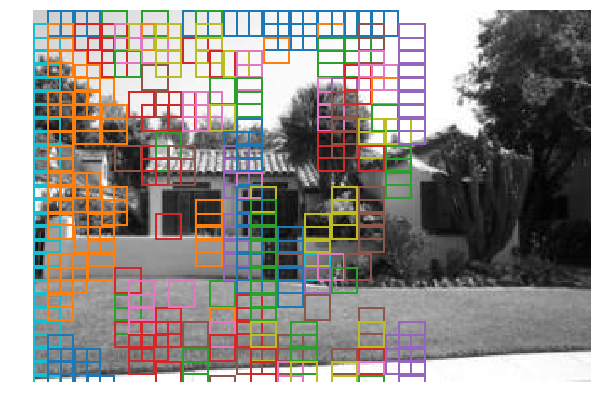

(9, 16, 16)


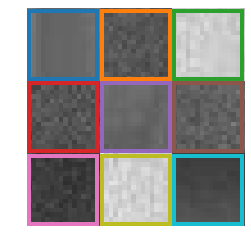

In [65]:
iname = inames[1]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=vd_regions) # if you have vdregions, add it as input here